In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
from sklearn.metrics import recall_score,r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, f1_score

In [3]:
import warnings
warnings.simplefilter('ignore')
from fbprophet import Prophet

In [4]:
url = 'Downloads/TIME_SERIES_SHEET/Time_series_analysis_and_forecast_DATASET.csv'

In [5]:
# reads the csv file and converts the column 'FullDate' to date format suitable for data manipulation
df =pd.read_csv(url, parse_dates=['FullDate'])

In [6]:
# Checking if there is a null value in the dataframe
df.isnull().sum()
# no null value detected. Hence no imputation or interpolation required

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

In [7]:
#Setting the FullDate column as index in order to use the Date functionality to manipulate the dataframe
df.set_index('FullDate', inplace=True)

In [8]:
#Resampling the dataframe from an hour sampling rate to Daily sampling rate while summing other columns as required
df_Un = df.resample('D').sum()
df_Mu = df.resample('D').sum()
df_2 = df.resample('D').sum()
df_Un
# 3 new dataframes created from resamping for future usage

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.38000,88.5600,2751.700
2010-09-02,369.6,38898.99000,88.5600,570.810
2010-09-03,439.2,41665.76000,106.8000,504.975
2010-09-04,328.8,35638.08500,81.3600,502.275
2010-09-05,357.6,35611.41000,106.8000,500.555
...,...,...,...,...
2021-02-24,537.6,-1525.49745,134.4000,634.770
2021-02-25,518.4,4539.07855,130.5048,577.515
2021-02-26,547.2,9517.02430,130.1808,1445.495


Text(0, 0.5, 'ElecPrice')

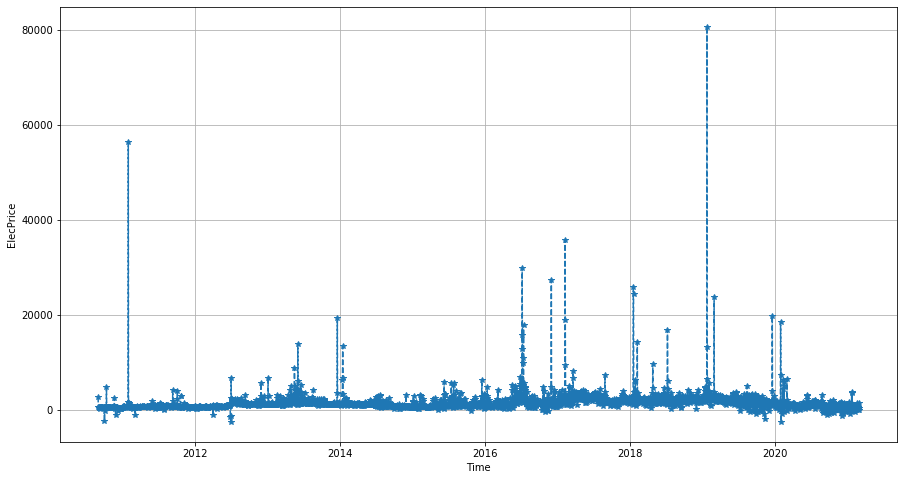

In [10]:
# Plotting Elecprice over time
plt.plot(df_Un.index, df_Mu.ElecPrice, '--', marker='*', )
plt.grid()
plt.xlabel('Time')
plt.ylabel('ElecPrice') 

In [13]:
# Using augmented DickyFuller Test to Evaluate P Values of SysLoad and GasPrice
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_Un['SysLoad'])
print(f'p-value: {adf_result[1]}')

#results in

adf2_result = adfuller(df_Un['GasPrice'])
print(f'p-value: {adf2_result[1]}')

p-value: 0.004253725504574104
p-value: 0.04502721288462575


In [15]:
# Finding 10% and 5% critical values of Gasprice and ElecPrice
adf3_result = adfuller(df_Un['GasPrice'])
print('Critical Values for GasPrice:')
for k, v in adf_result[4].items():
    print(f' {k}: {v}')

adf4_result = adfuller(df_Un['ElecPrice'])
print('Critical Values for ElecPrice:')
for k, v in adf_result[4].items():
    print(f' {k}: {v}')



Critical Values for GasPrice:
 1%: -3.432070672988693
 5%: -2.8623002987378547
 10%: -2.567174716967499
Critical Values for ElecPrice:
 1%: -3.432070672988693
 5%: -2.8623002987378547
 10%: -2.567174716967499


In [16]:
# Writing the MAPE function to calculate MAPE in % in 2 decimal places
def MAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray),
               isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),np.array(predicted)
        return round(np.mean(np.abs((actual-predicted)/actual))*100, 2)
    

In [17]:
df_Un.drop(['Tmax', 'SysLoad', 'GasPrice'], axis=1, inplace=True)

In [19]:
df_Un.reset_index(inplace=True)

In [21]:
df_Un.drop(['index'], axis=1, inplace=True)

In [22]:
df_Un

,FullDate,ElecPrice
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555
...,...,...
3829,2021-02-24,634.770
3830,2021-02-25,577.515
3831,2021-02-26,1445.495
3832,2021-02-27,488.980


In [23]:
df_Un.columns = ['ds', 'y']
df_Un

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555
...,...,...
3829,2021-02-24,634.770
3830,2021-02-25,577.515
3831,2021-02-26,1445.495
3832,2021-02-27,488.980


In [90]:
#Splitting test and training set
train = df_Un.iloc[:2757]
test = df_Un.iloc[2757:]

In [91]:
# training a prophet model
m = Prophet()
model= m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [92]:
# creating future dataframe for forcasting predictions
future = m.make_future_dataframe(periods=1077)
future.head()

,ds
0,2010-09-01
1,2010-09-02
2,2010-09-03
3,2010-09-04
4,2010-09-05


In [93]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2010-09-01,993.310795,-1325.540163,3282.463366,849.455287,849.455287,849.455287
1,2010-09-02,1073.567661,-1256.322811,3567.809130,849.407108,849.407108,849.407108
2,2010-09-03,848.484897,-1312.708753,3198.922560,849.358928,849.358928,849.358928
3,2010-09-04,508.113157,-1792.121600,2954.387060,849.310749,849.310749,849.310749
4,2010-09-05,418.091644,-1954.327021,2834.817038,849.262569,849.262569,849.262569
...,...,...,...,...,...,...,...
3829,2021-02-24,3445.867803,556.803190,6351.376316,3535.465368,1938.025960,5187.798758
3830,2021-02-25,3512.732595,650.458863,6294.270708,3536.257784,1938.124371,5189.713823
3831,2021-02-26,3279.538049,386.874429,6437.600113,3537.050200,1938.222781,5191.067107
3832,2021-02-27,2936.193807,-40.137495,6026.323905,3537.842616,1938.321192,5192.076706


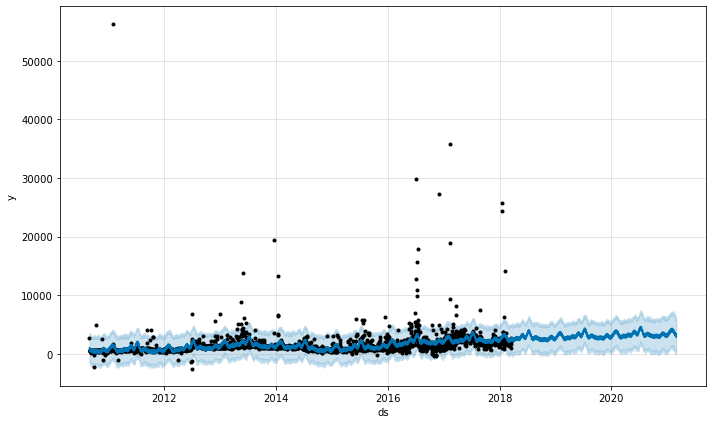

In [94]:
mo.plot(forecast)
plt.show()

In [29]:
# predicted and actual values
preds = forecast['yhat'].iloc[2757:]
act = test['y']

In [30]:
# the MAPE %
mape = MAPE(act, preds)

In [31]:
mape

544.76

In [33]:
# RMSE value
rmse = np.sqrt(mean_squared_error(act,preds))
round(rmse, 5)

3208.16976

## The Multivariate Prophet Model goes here

In [35]:
df_Mu

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.38000,88.5600,2751.700
2010-09-02,369.6,38898.99000,88.5600,570.810
2010-09-03,439.2,41665.76000,106.8000,504.975
2010-09-04,328.8,35638.08500,81.3600,502.275
2010-09-05,357.6,35611.41000,106.8000,500.555
...,...,...,...,...
2021-02-24,537.6,-1525.49745,134.4000,634.770
2021-02-25,518.4,4539.07855,130.5048,577.515
2021-02-26,547.2,9517.02430,130.1808,1445.495


In [36]:
df_Mu['FullDate'] = df_Mu.index # setting a column of date as the column of dates is recorgnised as index for now
df_Mu

,Tmax,SysLoad,GasPrice,ElecPrice,FullDate
FullDate,,,,,
2010-09-01,379.2,41565.38000,88.5600,2751.700,2010-09-01
2010-09-02,369.6,38898.99000,88.5600,570.810,2010-09-02
2010-09-03,439.2,41665.76000,106.8000,504.975,2010-09-03
2010-09-04,328.8,35638.08500,81.3600,502.275,2010-09-04
2010-09-05,357.6,35611.41000,106.8000,500.555,2010-09-05
...,...,...,...,...,...
2021-02-24,537.6,-1525.49745,134.4000,634.770,2021-02-24
2021-02-25,518.4,4539.07855,130.5048,577.515,2021-02-25
2021-02-26,547.2,9517.02430,130.1808,1445.495,2021-02-26


In [37]:
df_Mu.columns = ['Tmax', 'SysLoad', 'GasPrice','y', 'ds']

In [38]:
df_Mu.reset_index(inplace=True)
df_Mu

,FullDate,Tmax,SysLoad,GasPrice,y,ds
0,2010-09-01,379.2,41565.38000,88.5600,2751.700,2010-09-01
1,2010-09-02,369.6,38898.99000,88.5600,570.810,2010-09-02
2,2010-09-03,439.2,41665.76000,106.8000,504.975,2010-09-03
3,2010-09-04,328.8,35638.08500,81.3600,502.275,2010-09-04
4,2010-09-05,357.6,35611.41000,106.8000,500.555,2010-09-05
...,...,...,...,...,...,...
3829,2021-02-24,537.6,-1525.49745,134.4000,634.770,2021-02-24
3830,2021-02-25,518.4,4539.07855,130.5048,577.515,2021-02-25
3831,2021-02-26,547.2,9517.02430,130.1808,1445.495,2021-02-26
3832,2021-02-27,564.0,4932.88015,130.0800,488.980,2021-02-27


In [39]:
df_Mu.drop(['FullDate'], axis=1, inplace=True)
df_Mu

,Tmax,SysLoad,GasPrice,y,ds
0,379.2,41565.38000,88.5600,2751.700,2010-09-01
1,369.6,38898.99000,88.5600,570.810,2010-09-02
2,439.2,41665.76000,106.8000,504.975,2010-09-03
3,328.8,35638.08500,81.3600,502.275,2010-09-04
4,357.6,35611.41000,106.8000,500.555,2010-09-05
...,...,...,...,...,...
3829,537.6,-1525.49745,134.4000,634.770,2021-02-24
3830,518.4,4539.07855,130.5048,577.515,2021-02-25
3831,547.2,9517.02430,130.1808,1445.495,2021-02-26
3832,564.0,4932.88015,130.0800,488.980,2021-02-27


In [72]:
mo = Prophet()
mo.add_regressor('SysLoad')
mo.add_regressor('Tmax')
mo.add_regressor('GasPrice')

In [73]:
train_Mu = df_Mu.iloc[:2757]
test_Mu = df_Mu.iloc[2757:]

In [74]:
#Training the prophet model for the Multivariate model
mo.fit(train_Mu)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
future = mo.make_future_dataframe(periods=1077)
future['SysLoad'] = df_Mu['SysLoad']
future['Tmax'] = df_Mu['Tmax']
future['GasPrice'] = df_Mu['GasPrice']

In [76]:
forecast = mo.predict(future)
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-09-01,1505.573630,-727.256814,3861.241692
1,2010-09-02,1457.437060,-755.686603,3668.983056
2,2010-09-03,1687.531546,-591.789038,3751.701452
3,2010-09-04,901.874451,-1324.289743,2922.804916
4,2010-09-05,1320.069178,-849.639603,3642.031709
...,...,...,...,...
3829,2021-02-24,962.885249,-1393.076742,3218.384821
3830,2021-02-25,1322.210942,-1192.374966,3535.378764
3831,2021-02-26,1385.854102,-823.012720,3566.399766
3832,2021-02-27,1040.864173,-1350.172101,3502.673250


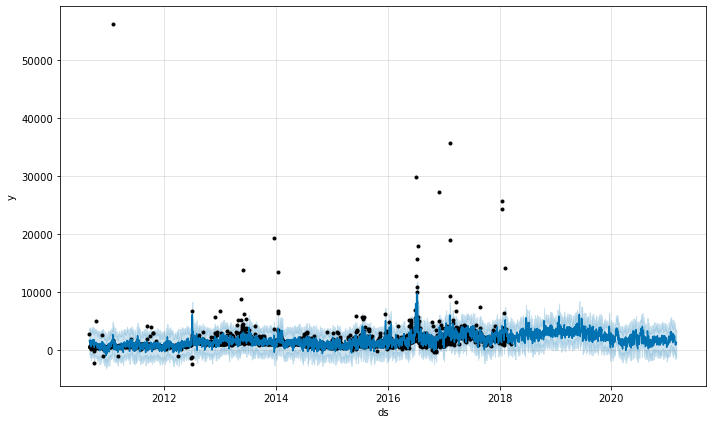

In [77]:
mo.plot(forecast)
plt.show()

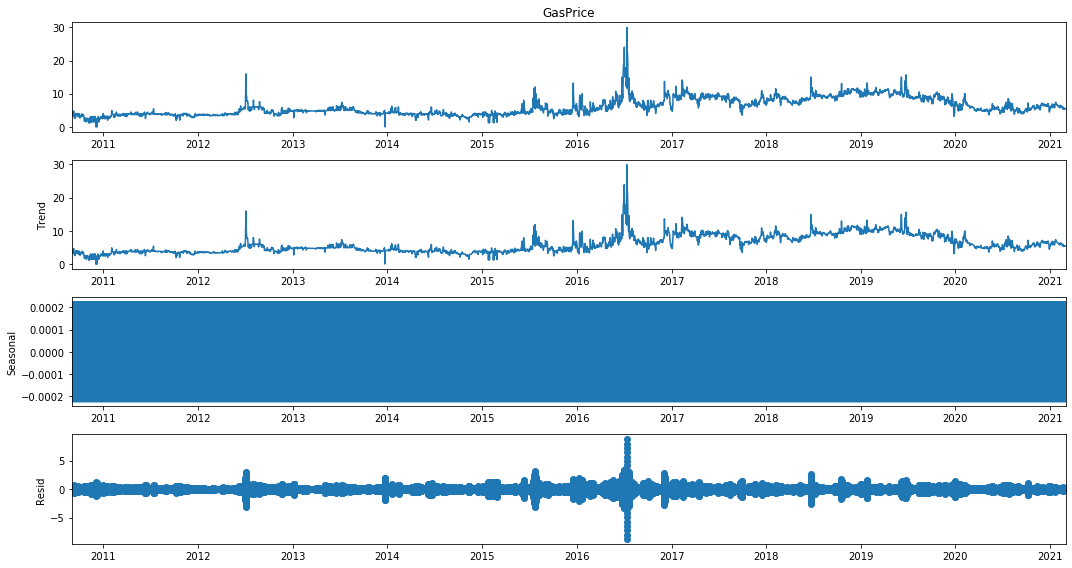

In [89]:
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(df['GasPrice'], model='additive')
decompose_series.plot()
plt.show()

In [46]:
pred = forecast['yhat'].iloc[2757:]
ac = test_Mu['y']

In [49]:
mate_MU = MAPE(ac, pred)
mate_MU

232.84

In [50]:
rmse_Mu = np.sqrt(mean_squared_error(ac,pred))
round(rmse_Mu, 5)

2708.59856

## Now excluding Tmax from training data

In [51]:
df_2

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.38000,88.5600,2751.700
2010-09-02,369.6,38898.99000,88.5600,570.810
2010-09-03,439.2,41665.76000,106.8000,504.975
2010-09-04,328.8,35638.08500,81.3600,502.275
2010-09-05,357.6,35611.41000,106.8000,500.555
...,...,...,...,...
2021-02-24,537.6,-1525.49745,134.4000,634.770
2021-02-25,518.4,4539.07855,130.5048,577.515
2021-02-26,547.2,9517.02430,130.1808,1445.495


In [52]:
df_2['FullDate'] = df_2.index # setting a column of date as the column of dates is recorgnised as index for now
df_2

,Tmax,SysLoad,GasPrice,ElecPrice,FullDate
FullDate,,,,,
2010-09-01,379.2,41565.38000,88.5600,2751.700,2010-09-01
2010-09-02,369.6,38898.99000,88.5600,570.810,2010-09-02
2010-09-03,439.2,41665.76000,106.8000,504.975,2010-09-03
2010-09-04,328.8,35638.08500,81.3600,502.275,2010-09-04
2010-09-05,357.6,35611.41000,106.8000,500.555,2010-09-05
...,...,...,...,...,...
2021-02-24,537.6,-1525.49745,134.4000,634.770,2021-02-24
2021-02-25,518.4,4539.07855,130.5048,577.515,2021-02-25
2021-02-26,547.2,9517.02430,130.1808,1445.495,2021-02-26


In [53]:
df_2.columns = ['Tmax', 'SysLoad', 'GasPrice','y', 'ds']

In [55]:
df_2.reset_index(inplace=True)
df_2.drop(['FullDate'], axis=1, inplace=True)
df_2

,Tmax,SysLoad,GasPrice,y,ds
0,379.2,41565.38000,88.5600,2751.700,2010-09-01
1,369.6,38898.99000,88.5600,570.810,2010-09-02
2,439.2,41665.76000,106.8000,504.975,2010-09-03
3,328.8,35638.08500,81.3600,502.275,2010-09-04
4,357.6,35611.41000,106.8000,500.555,2010-09-05
...,...,...,...,...,...
3829,537.6,-1525.49745,134.4000,634.770,2021-02-24
3830,518.4,4539.07855,130.5048,577.515,2021-02-25
3831,547.2,9517.02430,130.1808,1445.495,2021-02-26
3832,564.0,4932.88015,130.0800,488.980,2021-02-27


In [54]:
mo = Prophet()
mo.add_regressor('SysLoad')
mo.add_regressor('GasPrice')

In [60]:
train = df_2.iloc[:2757]
test = df_2.iloc[2757:]

In [61]:
train

,Tmax,SysLoad,GasPrice,y,ds
0,379.2,41565.38000,88.5600,2751.700,2010-09-01
1,369.6,38898.99000,88.5600,570.810,2010-09-02
2,439.2,41665.76000,106.8000,504.975,2010-09-03
3,328.8,35638.08500,81.3600,502.275,2010-09-04
4,357.6,35611.41000,106.8000,500.555,2010-09-05
...,...,...,...,...,...
2752,609.6,27139.02585,220.6272,2717.340,2018-03-15
2753,648.0,19710.46400,216.9600,2277.335,2018-03-16
2754,724.8,1079.34705,209.0400,1718.385,2018-03-17
2755,508.8,-4102.43795,203.9880,1088.015,2018-03-18


In [62]:
train.drop(['Tmax'], axis=1, inplace = True)
train

,SysLoad,GasPrice,y,ds
0,41565.38000,88.5600,2751.700,2010-09-01
1,38898.99000,88.5600,570.810,2010-09-02
2,41665.76000,106.8000,504.975,2010-09-03
3,35638.08500,81.3600,502.275,2010-09-04
4,35611.41000,106.8000,500.555,2010-09-05
...,...,...,...,...
2752,27139.02585,220.6272,2717.340,2018-03-15
2753,19710.46400,216.9600,2277.335,2018-03-16
2754,1079.34705,209.0400,1718.385,2018-03-17
2755,-4102.43795,203.9880,1088.015,2018-03-18


In [63]:
mo.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [65]:
future= mo.make_future_dataframe(periods=1077)
future['SysLoad'] = df_2['SysLoad']
future['GasPrice'] = df_2['GasPrice']

In [66]:
forecast = mo.predict(future)

In [67]:
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-09-01,1498.653216,-945.825826,3442.757174
1,2010-09-02,1449.633307,-715.576791,3817.866379
2,2010-09-03,1680.188886,-563.789790,4024.234951
3,2010-09-04,894.362404,-1280.710119,3093.465464
4,2010-09-05,1312.665566,-718.250840,3646.211239
...,...,...,...,...
3829,2021-02-24,969.285986,-1127.848898,3375.076637
3830,2021-02-25,1328.843523,-925.650930,3713.338264
3831,2021-02-26,1393.712737,-988.477907,3741.006554
3832,2021-02-27,1048.100096,-1365.644792,3343.552738


In [68]:
pred = forecast['yhat'].iloc[2757:]
actul = test['y']

In [69]:
mape_2 = MAPE(actul, pred)
mape_2

233.86